# Where would you open a Turkish Restaurant in Berlin?


## 1. Introduction  <a name="introduction"></a>

### 1.1 Background

Berlin is the capital and largest city of Germany by both area and population. Its 3,769,495 inhabitants as of 31 December 2019 make it the most populous city of the European Union, according to population within city limits. The city is also one of Germany's 16 federal states. It is surrounded by the state of Brandenburg, and contiguous with Potsdam, Brandenburg's capital. The two cities are at the center of the Berlin-Brandenburg capital region, which is, with about six million inhabitants and an area of more than 30,000 km2, Germany's third-largest metropolitan region after the Rhine-Ruhr and Rhine-Main regions.

### 1.2 Problem

Searching an optimal location to open a Turkish restaurant in the city of Berlin can be difficult. One could think that the better location for it should be at a place where there is no restaurants. But the problem is that perhaps most of the interested customers instead of going to an isolated neighborhood, prefer to go to a popular neighborhood, where there are more options and also there is movement of people. At the same time that the concurrence will be big in these regions, the flux of interested customers in this specific region will be relevant as well.

### 1.3 Interest

This project is to find an optimal place to open Turkish Restaurant.

Import some libraries first

In [ ]:
!pip install geocoder
import geocoder
from geopy.geocoders import Nominatim
from pygeocoder import Geocoder

import warnings
warnings.filterwarnings('ignore')

import pandas as pd # library for data analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
import numpy as np # library to handle data in a vectorized manner

import requests # library to handle requests

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter  
from matplotlib.ticker import PercentFormatter  

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported succesfully')

## 2. Data acquisition <a name="Data source "></a>

### 2.1 Data source 

The data and tools that I will use are the following:

* **Foursquare API** to select the number of restaurants and their location in some neighborhoods of Berlin
* **Geocoder** to get the latitudes and longitudes of places to rent

### 2.2 Feature selection

* First create a dataset thought the Foursquare API, exploring several types of venues, such as ID, name, category (Turkish restaurant), latitude, longitude, neighborhood, and distance (in meters) to Charllotenburg, a borough of Berlin, where is very famous to have Turkish restaurants. Then apply again the search using Foursquare API for public transportation categories, city train, and metro in Berlin. 

* At last, create another dataset that has information about available places to rent in Berlin. First, I will create the features "postal codes" and "prices" of these places and then with the help of Geocoder, I will get the latitude, longitude features. Then, I will save to a file CSV and read it with `Pandas`.

In [ ]:
CLIENT_ID = '*' # your Foursquare ID
CLIENT_SECRET = '*' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

In [3]:
# define Berlin's geolocation coordinates (center of Charllotenburg)
berlin_latitude = 52.50333132 #52.520008
berlin_longitude = 13.308665432 #13.404954

In [4]:
LIMIT = 500 # limit of number of venues returned by Foursquare API
radius = 15000 # define radius
category = '4f04af1f2fb6e1c99f3db0bb' # Turkish restaurants 
#category = '4bf58dd8d48988d1fc931735' # S-Bahnhof
#category = '4bf58dd8d48988d1fd931735' #U-Bahnhof

In [5]:
 url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
  CLIENT_ID, 
    CLIENT_SECRET, 
     VERSION, 
    berlin_latitude, 
    berlin_longitude, 
     category,
       radius, 
     LIMIT)

In [6]:
results = requests.get(url).json()
results.values();

In [7]:
 # a function which extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
       
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [10]:
venues = results['response']['groups'][0]['items']
venues_neighborhood = [results['response']['groups'][0]['items'][n]['venue']['location']['formattedAddress'] for n in range(len(venues))]  
venues_distance = [results['response']['groups'][0]['items'][n]['venue']['location']['distance'] for n in range(len(venues))]  
nearby_venues = json_normalize(venues) # flatten JSON

 # filter columns
filtered_columns = ['venue.id','venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

 # filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# # clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

[venues_neighborhood[k][0] for k in range(len(venues_neighborhood))]

#nearby_venues['neighborhood'] = venues_neighborhood[0][0]
nearby_venues['neighborhood'] =  [venues_neighborhood[k][0] for k in range(len(venues_neighborhood))]
nearby_venues['distance [m]'] = venues_distance

df = nearby_venues
df.head()

import os

outname = r'TurkishRestaurants.csv'

outdir = '/'
if not os.path.exists(outdir):
   os.mkdir(outdir)

fullname = os.path.join(outdir, outname)    

df.to_csv(fullname)

In [11]:
df_jc = pd.read_csv(r"TurkishRestaurants.csv")
df_jc.drop(['Unnamed: 0'], axis=1, inplace=True);
df_jc.drop(['distance [m]'], axis=1, inplace=True);
df_jc.head()

,id,name,categories,lat,lng,neighborhood
0,4af95d40f964a520771122e3,Restaurant Tuğra,Turkish Restaurant,52.498673,13.298555,Kurfürstendamm 96 (Markgraf-Albrecht-Str.)
1,504db200e4b05828d1ff6d4d,Bey Simit Haus,Turkish Restaurant,52.511215,13.298407,Kaiserdamm 66
2,4cf95af334c1a093ae95390e,Mercan,Turkish Restaurant,52.498589,13.427954,Wiener Str. 10
3,4b464c82f964a520e81c26e3,Doyum Grillhaus,Turkish Restaurant,52.498259,13.417375,Admiralstr. 38
4,4c45d1fbf0bdd13a317acbcc,Adana Grillhaus,Turkish Restaurant,52.499641,13.426887,Manteuffelstr. 86


In [12]:
df_s = pd.read_csv("sbahncategory.csv")
df_s.drop(['Unnamed: 0'], axis=1, inplace=True);
df_s.drop(['distance [m]'], axis=1, inplace=True);
df_s.head()

,id,name,categories,lat,lng,neighborhood
0,4a1c8506f964a520457b1fe3,Berlin Hauptbahnhof,Light Rail Station,52.525220,13.369369,Europaplatz 1 (Washingtonplatz)
1,4af5f0c7f964a52020ff21e3,Bahnhof Berlin Friedrichstraße,Light Rail Station,52.520284,13.387063,Georgenstr. 14/17
2,4b05bf38f964a5204ce222e3,Bahnhof Berlin Potsdamer Platz,Light Rail Station,52.509723,13.376597,Potsdamer Platz (Potsdamer Str.)
3,4adcda91f964a520ba4b21e3,Bahnhof Berlin Zoologischer Garten,Light Rail Station,52.506642,13.332513,Hardenbergplatz 13
4,4b01859ef964a520174322e3,S Savignyplatz,Light Rail Station,52.505093,13.319847,Bleibtreustr. 49


In [13]:
df_u = pd.read_csv("ubahn_data.csv")
df_u.drop(['Unnamed: 0'], axis=1, inplace=True);
df_u.drop(['distance [m]'], axis=1, inplace=True);
df_u.head()

,id,name,categories,lat,lng,neighborhood
0,4bfb2cf765fbc9b66f23916c,U Rehberge,Metro Station,52.555570,13.343412,Müllerstr. (Dubliner Str.)
1,4b538a1af964a52043a127e3,U Wilmersdorfer Straße,Metro Station,52.506312,13.306770,Wilmersdorfer Str. (Kantstr.)
2,4b5de986f964a520387329e3,U Adenauerplatz,Metro Station,52.499950,13.307203,Adenauerplatz (Kurfürstendamm)
3,4b47845cf964a5209e3426e3,U Güntzelstraße,Metro Station,52.490989,13.330868,Bundesallee (Güntzelstr.)
4,4b2a3edbf964a52076a624e3,U Deutsche Oper,Metro Station,52.511193,13.311905,Bismarckstr. (Krumme Str./Weimarer Str.)


In [14]:
df_rent = pd.DataFrame({'Postcode': [10247, 10777, 10713, 10719, 12359, 12057, 10785, 12043, 13595, 12053, 10435, 10119, 10245, 13597, 12347, 10115, 10717, 13585, 12057, 16727],'Price': [2400, 1142.36, 3269, 5900, 300, 400, 3900, 10000, 0, 1600, 2500, 3000, 1095, 0, 1000, 0, 2700, 570, 400, 0]})

In [15]:
df_rent.head()

,Postcode,Price
0,10247,2400.00
1,10777,1142.36
2,10713,3269.00
3,10719,5900.00
4,12359,300.00


Using Geocoder finding info about postal codes.

In [16]:
 def  get_latlng(postal_code):
     latlng_coords = None
     while(latlng_coords is None):
         g = geocoder.arcgis('{}, Berlin, Berlin'.format(postal_code))
         latlng_coords = g.latlng
     return latlng_coords

In [17]:
  codepost = df_rent['Postcode']
  coords = [get_latlng(postal_code) 
            for postal_code 
          in codepost.tolist()]

In [18]:
df_coords = pd.DataFrame(coords, columns = ['Latitude', 'Longitude'])
df_rent['Latitude'] = df_coords['Latitude']
df_rent['Longitude'] = df_coords['Longitude']

Save df_rent to a file and then read with pandas.

In [20]:
df_r = pd.read_csv("rent_data.csv")
df_r.drop(['Unnamed: 0'], axis=1, inplace=True);
df_r.head()

,Postcode,Price,Latitude,Longitude
0,12683,2900.00,52.503731,13.559540
1,10247,2400.00,52.516340,13.463990
2,10777,1142.36,52.497685,13.342285
3,10713,3269.00,52.485240,13.311870
4,10719,5900.00,52.498245,13.327140


Here we will understand more our data collection and we will apply some descriptive statistics to answer to following answers:

* How many restaurants exists?
* How many avaiable places to rent exist?
* How many categories exist in each dataset?

In [21]:
df_jc['categories'].describe()

count                    100
unique                    14
top       Turkish Restaurant
freq                      69
Name: categories, dtype: object

In [22]:
df_jc.categories.unique()

array(['Turkish Restaurant', 'Doner Restaurant', 'Breakfast Spot',
       'Mediterranean Restaurant', 'Bakery', 'Kebab Restaurant',
       'Steakhouse', 'Café', 'Fried Chicken Joint',
       'Turkish Home Cooking Restaurant', 'Restaurant',
       'Fast Food Restaurant', 'Middle Eastern Restaurant', 'Pastry Shop'],
      dtype=object)

In [23]:
df_r.count()

Postcode     21
Price        21
Latitude     21
Longitude    21
dtype: int64

In [25]:
#Adds a new column 
df_jc['categories_simplified'] = df_jc['categories']
df_jc.head(3)

,id,name,categories,lat,lng,neighborhood,categories_simplified
0,4af95d40f964a520771122e3,Restaurant Tuğra,Turkish Restaurant,52.498673,13.298555,Kurfürstendamm 96 (Markgraf-Albrecht-Str.),Turkish Restaurant
1,504db200e4b05828d1ff6d4d,Bey Simit Haus,Turkish Restaurant,52.511215,13.298407,Kaiserdamm 66,Turkish Restaurant
2,4cf95af334c1a093ae95390e,Mercan,Turkish Restaurant,52.498589,13.427954,Wiener Str. 10,Turkish Restaurant


In [27]:
df_jc.categories.unique()

array(['Turkish Restaurant', 'Doner Restaurant', 'Breakfast Spot',
       'Mediterranean Restaurant', 'Bakery', 'Kebab Restaurant',
       'Steakhouse', 'Café', 'Fried Chicken Joint',
       'Turkish Home Cooking Restaurant', 'Restaurant',
       'Fast Food Restaurant', 'Middle Eastern Restaurant', 'Pastry Shop'],
      dtype=object)

In [28]:
#renames values of categories to shorter names
df_jc = df_jc.replace({'categories_simplified': {'Turkish Restaurant': 'Restaurant', 
                                                 'Doner Restaurant': 'Doner',
                                                 'Breakfast Spot': 'Breakfast', 
                                                 'Mediterranean Restaurant': 'Mediterranean',
                                                 'Bakery': 'Bakery', 
                                                 'Kebab Restaurant': 'Kebap',
                                                 'Turkish Home Cooking Restaurant': 'Home Made',
                                                 'Fast Food Restaurant': 'Fast Food'}})

df_jc.tail(20)

,id,name,categories,lat,lng,neighborhood,categories_simplified
80,4b3750e7f964a520674025e3,Smyrna Kuruyemis,Restaurant,52.501141,13.419901,Oranienstr. 27,Restaurant
81,509134dfe4b0d71be3694691,Cigköftem,Turkish Restaurant,52.499894,13.418125,am Kotti,Restaurant
82,4e2714e7d16486291ba6aac4,Yeni Adana Grill,Doner Restaurant,52.499378,13.428943,Skalitzer Str. 99,Doner
83,4bdead160ee3a593637431b0,Fugger Imbiss,Fast Food Restaurant,52.498737,13.345941,Fuggerstr. 15,Fast Food
84,571a0278498e2192c0c1ea16,Mira Holzkohlengrill,Turkish Restaurant,52.466900,13.431750,Hermannstr. 157 (Silbersteinstr.),Restaurant
85,513b4d60e4b049104b868652,Favorit Gemüse Kebap,Doner Restaurant,52.526737,13.335998,Turmstr. 41,Doner
86,503a4134e4b05a7a71c12b8e,Café Peri,Café,52.491234,13.360889,Potsdamer Str. 203 (Großgörschenstr.),Café
87,4b0d74ccf964a520b94823e3,Hasir Restaurant,Turkish Restaurant,52.539028,13.146437,Breite Str. 43,Restaurant
88,4cb2f10faef16dcb8ba9c454,Black & White,Turkish Restaurant,52.501077,13.325078,Uhlandstr. 171-172,Restaurant
89,52cbf133498e78d875c9f01f,K'UPS Gemüsekebap,Doner Restaurant,52.539997,13.411222,Kastanienallee 102,Doner


In [29]:
df_jc.categories_simplified.unique()

array(['Restaurant', 'Doner', 'Breakfast', 'Mediterranean', 'Bakery',
       'Kebap', 'Steakhouse', 'Café', 'Fried Chicken Joint', 'Home Made',
       'Fast Food', 'Middle Eastern Restaurant', 'Pastry Shop'],
      dtype=object)

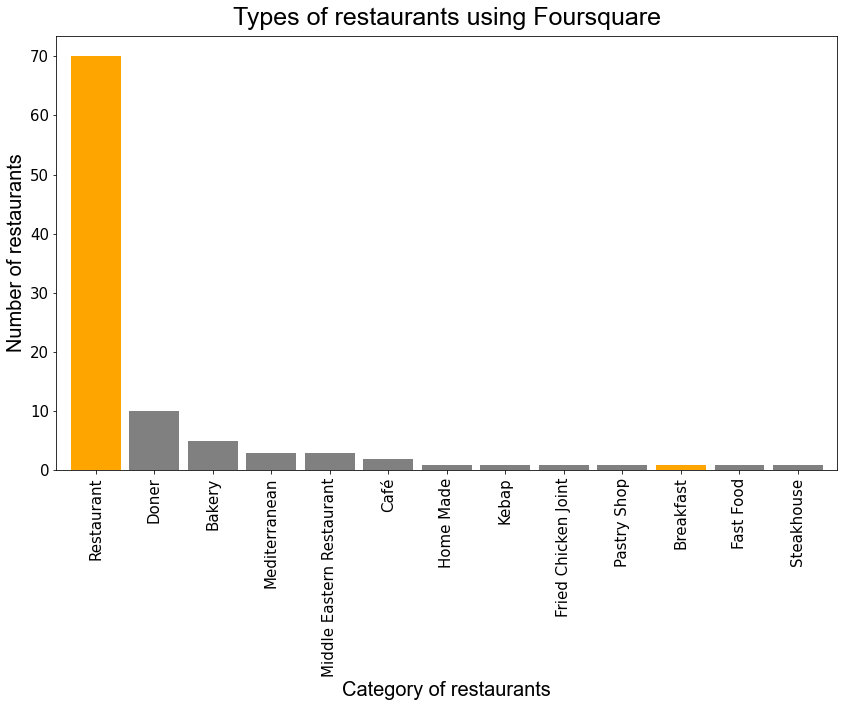

In [30]:
#ax = df_jc['categories'].value_counts().plot(kind='bar', figsize=(14,8), title="Japanese category venue")
#ax.set_xlabel("Category of restaurants")
#ax.set_ylabel("Frequency")

#Using Pandas
ax = df_jc['categories_simplified'].value_counts().plot(kind='bar', 
                                                   figsize=(14,8), 
                                                   width=.85,
                                                   color=['orange','gray','gray','gray',
                                                          'gray','gray', 'gray','gray',
                                                          'gray','gray'])                                         
                                                                                       
ax.set_title("Types of restaurants using Foursquare", fontname='Arial', fontsize=25, y=1.01)
ax.set_xlabel("Category of restaurants", fontname="Arial", fontsize=20)
ax.set_ylabel("Number of restaurants", fontname="Arial", fontsize=20) 
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)


## 3. Methodology

* The goal of this project is to search for locations which is optimal for Turkish restaurants. Then applying  **K-means Clustering** to make segmentations of the types of Turkish restaurants. After that, research about the prices to rent a place for opening a restaurant will be made. 
* In addition, the optimal location should be accessible by public transportation. 

Needed:
* number of existing Turkish restaurants
* prices and locations of places in Berlin to open a restaurant
* segmentation of types of Turkish restaurants in a neighborhood
* distance of the available places to rent to the Turkish restaurants that already exist and to public transportation.

K-means Clustering is a simple and popular unsupervised algorithm that can be used to make segmentation. Segmentation is a practice of divide a feature into groups with similar characteristics. Therefore one can get some insights from the characteristics of the data. 

First, applying the **One-hot Encoding** function to convert categorical variations to numerical ones. The results 0 indicates non-existent while 1 indicates existent.

In [31]:
# one hot encoding for Japanese category
#berlin_onehot = pd.get_dummies(df_jc[['categories']], prefix="", prefix_sep="")
berlin_onehot = pd.get_dummies(df_jc[['categories']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
#berlin_onehot['neighborhood'] = df_jc['neighborhood'] 
berlin_onehot['neighborhood'] = df_jc['neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [berlin_onehot.columns[-1]] + list(berlin_onehot.columns[:-1])
berlin_onehot = berlin_onehot[fixed_columns]
berlin_grouped = berlin_onehot.groupby('neighborhood').mean().reset_index()

In [32]:
berlin_onehot.head()

,neighborhood,Bakery,Breakfast Spot,Café,Doner Restaurant,Fast Food Restaurant,Fried Chicken Joint,Kebab Restaurant,Mediterranean Restaurant,Middle Eastern Restaurant,Pastry Shop,Restaurant,Steakhouse,Turkish Home Cooking Restaurant,Turkish Restaurant
0,Kurfürstendamm 96 (Markgraf-Albrecht-Str.),0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,Kaiserdamm 66,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,Wiener Str. 10,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,Admiralstr. 38,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,Manteuffelstr. 86,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [33]:
berlin_grouped = berlin_onehot.groupby('neighborhood').mean().reset_index()

Now I will create a dataset in `Pandas`. For this, I will use a function to sort the venues in descending order.

In [34]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
    

Here I will create a new dataset and display the top 7 venues for each neighborhood.

In [35]:
num_top_venues = 7

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))  
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))  

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['neighborhood'] = berlin_grouped['neighborhood']

for ind in np.arange(berlin_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(berlin_grouped.iloc[ind, :], num_top_venues)

In [36]:
neighborhoods_venues_sorted.head()

,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
0,Adalbertstr. 10,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant,Mediterranean Restaurant
1,Adalbertstr. 12,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant,Mediterranean Restaurant
2,Adalbertstr. 97,Bakery,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant
3,Adalbertstraße 98,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant,Mediterranean Restaurant
4,Admiralstr. 38,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant,Mediterranean Restaurant


### 3.1 Cluster Neighborhoods

I will run *k*-means to cluster the neighborhood into 5 clusters.

In [37]:
# set number of clusters
kclusters = 5

berlin_grouped_clustering = berlin_grouped.drop('neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(berlin_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 4, 1, 1, 1, 1, 1, 1, 1])

In [38]:
kmeans_cluster_centers = kmeans.cluster_centers_
kmeans_cluster_centers.shape

(5, 14)

In [39]:
neighborhoods_venues_sorted.insert(0,'Cluster Labels', kmeans.labels_)

In [40]:
neighborhoods_venues_sorted.head()

,Cluster Labels,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
0,1,Adalbertstr. 10,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant,Mediterranean Restaurant
1,1,Adalbertstr. 12,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant,Mediterranean Restaurant
2,4,Adalbertstr. 97,Bakery,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant
3,1,Adalbertstraße 98,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant,Mediterranean Restaurant
4,1,Admiralstr. 38,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant,Mediterranean Restaurant


In [41]:
df_jc.head()

,id,name,categories,lat,lng,neighborhood,categories_simplified
0,4af95d40f964a520771122e3,Restaurant Tuğra,Turkish Restaurant,52.498673,13.298555,Kurfürstendamm 96 (Markgraf-Albrecht-Str.),Restaurant
1,504db200e4b05828d1ff6d4d,Bey Simit Haus,Turkish Restaurant,52.511215,13.298407,Kaiserdamm 66,Restaurant
2,4cf95af334c1a093ae95390e,Mercan,Turkish Restaurant,52.498589,13.427954,Wiener Str. 10,Restaurant
3,4b464c82f964a520e81c26e3,Doyum Grillhaus,Turkish Restaurant,52.498259,13.417375,Admiralstr. 38,Restaurant
4,4c45d1fbf0bdd13a317acbcc,Adana Grillhaus,Turkish Restaurant,52.499641,13.426887,Manteuffelstr. 86,Restaurant


In [42]:
# add clustering labels
#neighborhoods_venues_sorted.insert(0,'Cluster Labels', kmeans.labels_)

berlin_merged = df_jc

# merge berlin_grouped with berlin_data to add latitude/longitude for each neighborhood
berlin_merged = berlin_merged.join(neighborhoods_venues_sorted.set_index('neighborhood'), on='neighborhood')
berlin_merged.head() # check the last columns!

,id,name,categories,lat,lng,neighborhood,categories_simplified,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
0,4af95d40f964a520771122e3,Restaurant Tuğra,Turkish Restaurant,52.498673,13.298555,Kurfürstendamm 96 (Markgraf-Albrecht-Str.),Restaurant,1,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant,Mediterranean Restaurant
1,504db200e4b05828d1ff6d4d,Bey Simit Haus,Turkish Restaurant,52.511215,13.298407,Kaiserdamm 66,Restaurant,1,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant,Mediterranean Restaurant
2,4cf95af334c1a093ae95390e,Mercan,Turkish Restaurant,52.498589,13.427954,Wiener Str. 10,Restaurant,1,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant,Mediterranean Restaurant
3,4b464c82f964a520e81c26e3,Doyum Grillhaus,Turkish Restaurant,52.498259,13.417375,Admiralstr. 38,Restaurant,1,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant,Mediterranean Restaurant
4,4c45d1fbf0bdd13a317acbcc,Adana Grillhaus,Turkish Restaurant,52.499641,13.426887,Manteuffelstr. 86,Restaurant,1,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant,Mediterranean Restaurant


## 4. Analysis  <a name="Analysis"></a>

Now that we applied the **K-mean Clustering**, I will analyze each cluster and create datasets for each of them. 

### Cluster 0

In [43]:
berlin_merged.loc[berlin_merged['Cluster Labels'] == 0, berlin_merged.columns[[0] + list(range(5, berlin_merged.shape[1]))]].head()

,id,neighborhood,categories_simplified,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
39,506d4dcce4b00cdc7b6107cf,Chausseestr. 101,Breakfast,0,Breakfast Spot,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant
66,530a30ea11d2d04bbcd9819c,Kurfürstendamm 72 (Waitzstr.),Steakhouse,0,Steakhouse,Turkish Restaurant,Turkish Home Cooking Restaurant,Restaurant,Pastry Shop,Middle Eastern Restaurant,Mediterranean Restaurant
71,5144aa4fe4b042f54148cc85,Reuterstr. 75 (Donaustr.),Café,0,Café,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant
75,4bc2f443abf495211814c393,Sonnenallee 26,Fried Chicken Joint,0,Fried Chicken Joint,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant
79,529b562111d248489a0afea9,Hermannstraße 120,Home Made,0,Turkish Home Cooking Restaurant,Turkish Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant,Mediterranean Restaurant


In [44]:
berlin_merged['categories'].loc[berlin_merged['Cluster Labels'] == 0].count()

12

In [45]:
berlin_merged.loc[berlin_merged['Cluster Labels'] == 0, berlin_merged.columns[[0] + list(range(5, berlin_merged.shape[1]))]].head()

,id,neighborhood,categories_simplified,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
39,506d4dcce4b00cdc7b6107cf,Chausseestr. 101,Breakfast,0,Breakfast Spot,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant
66,530a30ea11d2d04bbcd9819c,Kurfürstendamm 72 (Waitzstr.),Steakhouse,0,Steakhouse,Turkish Restaurant,Turkish Home Cooking Restaurant,Restaurant,Pastry Shop,Middle Eastern Restaurant,Mediterranean Restaurant
71,5144aa4fe4b042f54148cc85,Reuterstr. 75 (Donaustr.),Café,0,Café,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant
75,4bc2f443abf495211814c393,Sonnenallee 26,Fried Chicken Joint,0,Fried Chicken Joint,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant
79,529b562111d248489a0afea9,Hermannstraße 120,Home Made,0,Turkish Home Cooking Restaurant,Turkish Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant,Mediterranean Restaurant


### Cluster 1

In [46]:
clusterone = berlin_merged.loc[berlin_merged['Cluster Labels'] == 1, berlin_merged.columns[[1] + list(range(5, berlin_merged.shape[1]))]]
berlin_merged['categories'].loc[berlin_merged['Cluster Labels'] == 1].count()

71

In [47]:
berlin_merged.loc[berlin_merged['Cluster Labels'] == 1, berlin_merged.columns[[1] + list(range(5, berlin_merged.shape[1]))]]

,name,neighborhood,categories_simplified,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
0,Restaurant Tuğra,Kurfürstendamm 96 (Markgraf-Albrecht-Str.),Restaurant,1,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant,Mediterranean Restaurant
1,Bey Simit Haus,Kaiserdamm 66,Restaurant,1,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant,Mediterranean Restaurant
2,Mercan,Wiener Str. 10,Restaurant,1,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant,Mediterranean Restaurant
3,Doyum Grillhaus,Admiralstr. 38,Restaurant,1,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant,Mediterranean Restaurant
4,Adana Grillhaus,Manteuffelstr. 86,Restaurant,1,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant,Mediterranean Restaurant
5,Recep Usta Köfteci,Turmstr. 76,Restaurant,1,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant,Mediterranean Restaurant
6,Osmans Töchter,Pappelallee 15,Restaurant,1,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant,Mediterranean Restaurant
7,La Femme,Kottbusser Damm 77 (Pflügerstr.),Restaurant,1,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant,Mediterranean Restaurant
8,Baba Pirzola,Bayreuther Str. 35,Restaurant,1,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant,Mediterranean Restaurant
9,Fes Turkish BBQ,Hasenheide 58,Restaurant,1,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant,Mediterranean Restaurant


### Cluster 2

In [48]:
clustertwo = berlin_merged.loc[berlin_merged['Cluster Labels'] == 2, berlin_merged.columns[[1] + list(range(5, berlin_merged.shape[1]))]]

In [49]:
berlin_merged['categories'].loc[berlin_merged['Cluster Labels'] == 2].count()

3

In [50]:
berlin_merged.loc[berlin_merged['Cluster Labels'] == 2, berlin_merged.columns[[1] + list(range(5, berlin_merged.shape[1]))]].head()

,name,neighborhood,categories_simplified,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
48,Meyan,Goltzstr. 36,Mediterranean,2,Mediterranean Restaurant,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant
58,Knofi Feinkost,Bergmannstr. 98,Mediterranean,2,Mediterranean Restaurant,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant
69,Pi Mediterran,Gärtnerstr 17,Mediterranean,2,Mediterranean Restaurant,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant


### Cluster 3

In [51]:
berlin_merged.loc[berlin_merged['Cluster Labels'] == 3, berlin_merged.columns[[1] + list(range(5, berlin_merged.shape[1]))]]

,name,neighborhood,categories_simplified,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
27,Baba Angora,Schlüterstr. 29 (Niebuhrstr.),Doner,3,Doner Restaurant,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant
57,Rüyam Gemüse Kebab,Hauptstr. 133,Doner,3,Doner Restaurant,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant
68,Mustafa’s Gemüse Kebap,Mehringdamm 32-34,Doner,3,Doner Restaurant,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant
82,Yeni Adana Grill,Skalitzer Str. 99,Doner,3,Doner Restaurant,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant
85,Favorit Gemüse Kebap,Turmstr. 41,Doner,3,Doner Restaurant,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant
89,K'UPS Gemüsekebap,Kastanienallee 102,Doner,3,Doner Restaurant,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant
90,7 Days - Finest Fresh Food,Hauptstr. 21,Doner,3,Doner Restaurant,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant
92,Hisar Fresh Food,Yorckstr. 49,Doner,3,Doner Restaurant,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant
97,XL Döner Sophie,Schloßstraße 28,Doner,3,Doner Restaurant,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant


In [52]:
berlin_merged['categories'].loc[berlin_merged['Cluster Labels'] == 3].count()

9

In [53]:
berlin_merged.loc[berlin_merged['Cluster Labels'] == 3, berlin_merged.columns[[1] + list(range(5, berlin_merged.shape[1]))]]

,name,neighborhood,categories_simplified,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
27,Baba Angora,Schlüterstr. 29 (Niebuhrstr.),Doner,3,Doner Restaurant,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant
57,Rüyam Gemüse Kebab,Hauptstr. 133,Doner,3,Doner Restaurant,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant
68,Mustafa’s Gemüse Kebap,Mehringdamm 32-34,Doner,3,Doner Restaurant,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant
82,Yeni Adana Grill,Skalitzer Str. 99,Doner,3,Doner Restaurant,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant
85,Favorit Gemüse Kebap,Turmstr. 41,Doner,3,Doner Restaurant,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant
89,K'UPS Gemüsekebap,Kastanienallee 102,Doner,3,Doner Restaurant,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant
90,7 Days - Finest Fresh Food,Hauptstr. 21,Doner,3,Doner Restaurant,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant
92,Hisar Fresh Food,Yorckstr. 49,Doner,3,Doner Restaurant,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant
97,XL Döner Sophie,Schloßstraße 28,Doner,3,Doner Restaurant,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant


### Cluster 4

In [54]:
berlin_merged.loc[berlin_merged['Cluster Labels'] == 4, berlin_merged.columns[[1] + list(range(5, berlin_merged.shape[1]))]]

,name,neighborhood,categories_simplified,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
50,Leylak,Kottbusser Str. 25,Bakery,4,Bakery,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant
56,Melek Pastanesi,Oranienstr. 28 (Adalbertstr.),Bakery,4,Bakery,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant
62,Hak-Bäckerei,Hochstädter Str. 24 (Liebenwalder Str.),Bakery,4,Bakery,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant
70,Simitdchi Café & BackHaus,Adalbertstr. 97,Bakery,4,Bakery,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant
98,Café Bäckerei Bonjour,Markgrafenstr. 19,Bakery,4,Bakery,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant


In [55]:
berlin_merged['categories'].loc[berlin_merged['Cluster Labels'] == 4].count()

5

In [56]:
berlin_merged.loc[berlin_merged['Cluster Labels'] == 4, berlin_merged.columns[[1] + list(range(5, berlin_merged.shape[1]))]]

,name,neighborhood,categories_simplified,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
50,Leylak,Kottbusser Str. 25,Bakery,4,Bakery,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant
56,Melek Pastanesi,Oranienstr. 28 (Adalbertstr.),Bakery,4,Bakery,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant
62,Hak-Bäckerei,Hochstädter Str. 24 (Liebenwalder Str.),Bakery,4,Bakery,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant
70,Simitdchi Café & BackHaus,Adalbertstr. 97,Bakery,4,Bakery,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant
98,Café Bäckerei Bonjour,Markgrafenstr. 19,Bakery,4,Bakery,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant


Here we will calculate the score of the available places to rent to the Japanese restaurants that already exists and to the public transportation.

In [57]:
!pip install shapely
import shapely

!pip install pyproj
import pyproj

import math

def lonlat_to_xy(lon, lat):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
    return xy[0], xy[1]

def xy_to_lonlat(x, y):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
    return lonlat[0], lonlat[1]

def calc_xy_distance(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    return math.sqrt(dx*dx + dy*dy)

In [59]:
X = list(berlin_merged['lat']);
Y = list(berlin_merged['lng']);
x, y = lonlat_to_xy(X, Y)
turkish_list = [(x[n],y[n]) for n in range(len(x))]
turkish_list;

In [60]:
X1 = list(df_r['Latitude']);
Y1 = list(df_r['Longitude']);
x1, y1 = lonlat_to_xy(X1, Y1)
rent_list = [(x1[n],y1[n]) for n in range(len(x1))]
rent_list;

In [61]:
X2 = list(df_s['lat']);
Y2 = list(df_s['lng']);
x2, y2 = lonlat_to_xy(X2, Y2)
sbahn_list = [(x2[n],y2[n]) for n in range(len(x2))]
sbahn_list;

In [62]:
X3 = list(df_u['lat']);
Y3 = list(df_u['lng']);
x3, y3 = lonlat_to_xy(X3, Y3)
ubahn_list = [(x3[n],y3[n]) for n in range(len(x3))]
ubahn_list;

In [63]:
optimal_list=[]

In [64]:
for place_to_rent in rent_list:
    distances_to_restaurants = [calc_xy_distance(place_to_rent[0], place_to_rent[1], jap[0], jap[1]) for jap in turkish_list]
    closest_restaurant = min(distances_to_restaurants)
    
    distances_to_transport = [calc_xy_distance(place_to_rent[0], place_to_rent[1], transp[0], transp[1]) for transp in sbahn_list]
    closest_transport = min(distances_to_transport)
    
    optimal_list.append((closest_transport)+abs(closest_restaurant - 300))

In [65]:
optimal_list;

In [66]:
df_optimal=pd.DataFrame(optimal_list,columns=['Score'])

In [67]:
df_optimal['Score'].head()

0    16757.044480
1     1487.424275
2     1992.547554
3     2602.664191
4     1525.615759
Name: Score, dtype: float64

In [68]:
df_r['Score'] = df_optimal['Score']
df_r.head()

,Postcode,Price,Latitude,Longitude,Score
0,12683,2900.00,52.503731,13.559540,16757.044480
1,10247,2400.00,52.516340,13.463990,1487.424275
2,10777,1142.36,52.497685,13.342285,1992.547554
3,10713,3269.00,52.485240,13.311870,2602.664191
4,10719,5900.00,52.498245,13.327140,1525.615759


In [69]:
df_address = pd.DataFrame({'Postcode': [12683, 10247, 10777, 10713, 10719, 12359, 12057, 10785, 12043, 13595, 12053, 10435, 10119, 10245, 13597, 12347, 10115, 10717, 13585, 12057, 16727],'Address': ['Wulkower Straße 10, Biesdorf', 'Silvio-Meier-Straße 8, Friedrichshain', 'Welserstraße 14D, Schöneberg', 'Barstraße, Wilmersdorf', 'Fasanenplatz, Wilmersdorf', 'Malchiner Straße 55, Britz', 'Sonnenallee 289, Neukölln', 'Stauffenbergstraße 1, Tiergarten', 'Donaustraße 94, Neukölln', 'Heerstraße 243, Pichelsdorf', 'Morusstraße 18A, Neukölln', 'Choriner Straße 49, Prenzlauer Berg', 'Zehdenicker Straße 21, Mitte', 'Corinthstraße 7, Friedrichshain', 'Kolonie Tiefwerder Brücke 1, Wilhelmstadt', 'Alpenhöhe (43 - 47a), Britz', 'Zinnowitzer Straße 2, Mitte', 'Trautenaustraße 14, Wilmersdorf', 'Neumeisterstraße 5, Neustadt', 'Sonnenallee 289, Neukölln', 'Ebertstraße, Mitte']})

In [70]:
df_address

,Postcode,Address
0,12683,"Wulkower Straße 10, Biesdorf"
1,10247,"Silvio-Meier-Straße 8, Friedrichshain"
2,10777,"Welserstraße 14D, Schöneberg"
3,10713,"Barstraße, Wilmersdorf"
4,10719,"Fasanenplatz, Wilmersdorf"
5,12359,"Malchiner Straße 55, Britz"
6,12057,"Sonnenallee 289, Neukölln"
7,10785,"Stauffenbergstraße 1, Tiergarten"
8,12043,"Donaustraße 94, Neukölln"
9,13595,"Heerstraße 243, Pichelsdorf"


In [71]:
df_r['Address'] = df_address['Address']

In [72]:
df_r = df_r.sort_values(by=['Score']).reset_index()

In [73]:
df_r.shape

(21, 7)

In [74]:
df_r = df_r.set_index('Address')

In [75]:
df_r.head()

,index,Postcode,Price,Latitude,Longitude,Score
Address,,,,,,
"Zinnowitzer Straße 2, Mitte",16,10115,0.0,52.531570,13.383444,766.208259
"Donaustraße 94, Neukölln",8,12043,10000.0,52.480500,13.439106,1130.735155
"Silvio-Meier-Straße 8, Friedrichshain",1,10247,2400.0,52.516340,13.463990,1487.424275
"Fasanenplatz, Wilmersdorf",4,10719,5900.0,52.498245,13.327140,1525.615759
"Morusstraße 18A, Neukölln",10,12053,1600.0,52.477260,13.432515,1691.377378


## 5. Results and discussions  <a name="Results and discussions"></a>

In this section, I will show some of the results obtained. I segmented the category features into five Clusters and I can see the **1st Most Common Venue** in each of these clusters, see the figure below, where shows the result of applying the **K-mean Clustering**. 

In [76]:
berlin_merged.tail(3)

,id,name,categories,lat,lng,neighborhood,categories_simplified,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
97,4c8aa11c1eafb1f758077c35,XL Döner Sophie,Doner Restaurant,52.511749,13.297073,Schloßstraße 28,Doner,3,Doner Restaurant,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant
98,4cf39fb83e996a31b128ea8f,Café Bäckerei Bonjour,Bakery,52.506933,13.394422,Markgrafenstr. 19,Bakery,4,Bakery,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Pastry Shop,Middle Eastern Restaurant
99,51b5c326498e2c9c8514276d,La Femme Pâtisserie,Pastry Shop,52.568646,13.362165,Residenzstr. 128,Pastry Shop,0,Pastry Shop,Turkish Restaurant,Turkish Home Cooking Restaurant,Steakhouse,Restaurant,Middle Eastern Restaurant,Mediterranean Restaurant


In [77]:
list_columns=list(berlin_merged)  # shows the columns

In [78]:
berlin_merged.to_csv('berlin_merged.csv')

In [79]:
#Rename column head 
berlin_merged = berlin_merged.rename(columns = {'Cluster Labels': 'cluster_labels', 
                                                '1st Most Common Venue':'top_venues_categories'}) 
berlin_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     100 non-null    object 
 1   name                   100 non-null    object 
 2   categories             100 non-null    object 
 3   lat                    100 non-null    float64
 4   lng                    100 non-null    float64
 5   neighborhood           100 non-null    object 
 6   categories_simplified  100 non-null    object 
 7   cluster_labels         100 non-null    int32  
 8   top_venues_categories  100 non-null    object 
 9   2nd Most Common Venue  100 non-null    object 
 10  3rd Most Common Venue  100 non-null    object 
 11  4th Most Common Venue  100 non-null    object 
 12  5th Most Common Venue  100 non-null    object 
 13  6th Most Common Venue  100 non-null    object 
 14  7th Most Common Venue  100 non-null    object 
dtypes: floa

In [80]:
#Finds the top venue's categories per cluster
top_venues_category = berlin_merged.groupby('cluster_labels')['top_venues_categories'].apply(lambda x: x.value_counts().index[0]).reset_index()
top_venues_category

,cluster_labels,top_venues_categories
0,0,Middle Eastern Restaurant
1,1,Turkish Restaurant
2,2,Mediterranean Restaurant
3,3,Doner Restaurant
4,4,Bakery


In [81]:
# displays column value based on frequency value of another column in pandas
freq_top_venue_cat = berlin_merged.groupby('cluster_labels').top_venues_categories.agg(['count', 'first'])
freq_top_venue_cat 

,count,first
cluster_labels,,
0,12,Breakfast Spot
1,71,Turkish Restaurant
2,3,Mediterranean Restaurant
3,9,Doner Restaurant
4,5,Bakery


In [82]:
# counts how many times the most common venue category appears in the cluster (equivalent to COUNTIFS, from Excel) 
count_top_venue_cluster_0 = (berlin_merged[berlin_merged['top_venues_categories'] == 'Sushi Restaurant']['cluster_labels'] == 0).count()
count_top_venue_cluster_1 = (berlin_merged[berlin_merged['top_venues_categories'] == 'Ramen Restaurant']['cluster_labels'] == 1).count()
count_top_venue_cluster_2 = (berlin_merged[berlin_merged['top_venues_categories'] == 'Japanese Restaurant']['cluster_labels'] == 2).count()
count_top_venue_cluster_3 = (berlin_merged[berlin_merged['top_venues_categories'] == 'Vietnamese Restaurant']['cluster_labels'] == 3).count()
count_top_venue_cluster_4 = (berlin_merged[berlin_merged['top_venues_categories'] == 'Asian Restaurant']['cluster_labels'] == 4).count()
print('cluster0:' + str(count_top_venue_cluster_0),
      'cluster1:' + str(count_top_venue_cluster_1), 
      'cluster2:' + str(count_top_venue_cluster_2), 
      'cluster3:' + str(count_top_venue_cluster_3),
      'cluster4:' + str(count_top_venue_cluster_4))  


cluster0:0 cluster1:0 cluster2:0 cluster3:0 cluster4:0


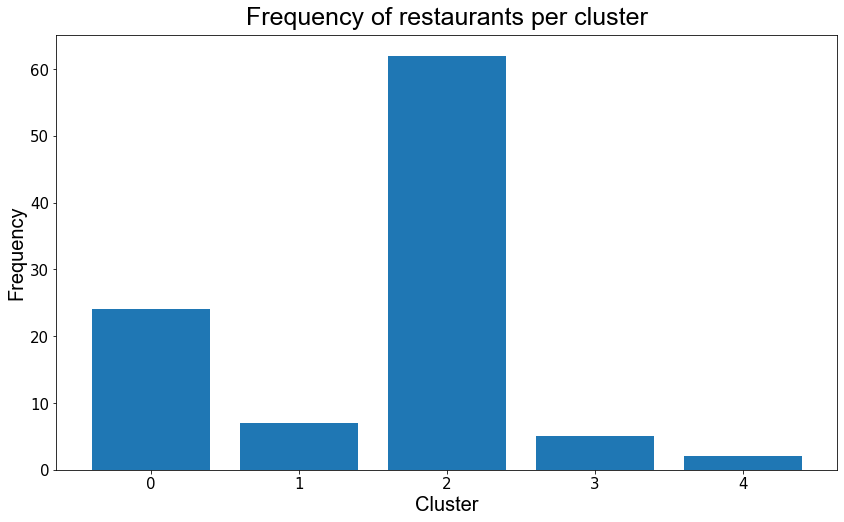

In [83]:
clusters = ['0','1','2','3','4']   #axis X     #clusters
frequency = [24,7,62, 5,2]   #axis Y   #number of resturant by cluster.

#x = np.arange(len(label))  # the label locations
width = 0.35  # the width of the bars

#figsize=(14,8)
fig, ax = plt.subplots(figsize=(14, 8))

ax.bar(clusters, frequency)

ax.set_title('Frequency of restaurants per cluster', fontname='Arial', fontsize=25, y=1.01)
ax.set_xlabel('Cluster', fontname='Arial', fontsize=20,  y=1.01)
ax.set_ylabel('Frequency', fontname='Arial', fontsize=20) 

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(15) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)

plt.show()


I calculated the score of the available places to rent to the Turkish restaurants that already exist and to public transportation. The lower score more optimal is the place. The results are shown in the figure below. 

In [84]:
#df_r.info()
#df_r.head()
df_r.describe()

,index,Postcode,Price,Latitude,Longitude,Score
count,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
mean,10.000000,11808.333333,2051.255238,52.499874,13.381945,3846.659278
std,6.204837,1635.782422,2406.809748,0.027930,0.095382,3678.038451
min,0.000000,10115.000000,0.000000,52.446285,13.191231,766.208259
25%,5.000000,10713.000000,400.000000,52.480500,13.327373,1937.454523
50%,10.000000,12043.000000,1142.360000,52.501540,13.405483,2602.664191
75%,15.000000,12359.000000,2900.000000,52.516340,13.453565,3989.465133
max,20.000000,16727.000000,10000.000000,52.547630,13.559540,16757.044480


In [85]:
df_r = df_r.reset_index()  #reset index   

In [86]:
'''
Variables:
categorical nominal: address, postcode
quantitative continuous: price
categorical quantitative: distance
'''

'\nVariables:\ncategorical nominal: address, postcode\nquantitative continuous: price\ncategorical quantitative: distance\n'

In [87]:
# list(df_r.columns) #list columns names
list_postcode = df_r.Postcode.unique()   #liste vaules por Postcode
list_postcode

array([10115, 12043, 10247, 10719, 12053, 10435, 10119, 10777, 10245,
       16727, 10713, 10717, 10785, 12057, 13585, 12347, 13597, 12359,
       13595, 12683], dtype=int64)

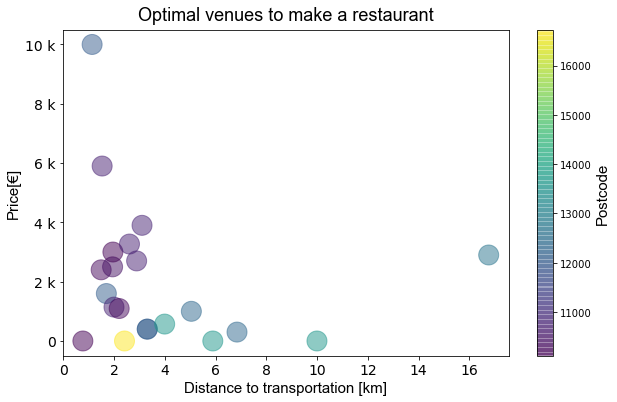

In [88]:
# Multivariable graph (price, distance to public transportation and Postcode). With a color bar.

x = df_r['Score']/1000  #defines x and transforms m in km
y = df_r['Price']
z = df_r['Postcode']

fig, ax = plt.subplots(figsize=(10,6))
scat = ax.scatter(x, y, c=z, s=400, marker='o',alpha=0.5)
cb = fig.colorbar(scat)

ax.set_title("Optimal venues to make a restaurant", fontname='Arial', fontsize=18, y=1.01)
ax.set_xlabel("Distance to transportation [km]", fontname="Arial", fontsize=15)
ax.set_ylabel("Price[€]", fontname="Arial", fontsize=15) 
plt.gca().xaxis.set_major_formatter(EngFormatter())
plt.gca().yaxis.set_major_formatter(EngFormatter())
cb.set_label('Postcode', fontname="Arial", fontsize=15)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)



I will explore the results now using the `Folium map`. In the Berlin map below is showing the locations of each cluster and each type of the restaurant. It is also showing in the figure the optimal places (yellow points) with the score label in each point and including the public transportation, the city train - s-Bahn (green points) and the metro - U-Bahn (blue points).

In [89]:
#berlin_map = folium.Map(location=[berlin_latitude, berlin_longitude], zoom_start=10)
# create map
map_clusters = folium.Map(location=[berlin_latitude, berlin_longitude], zoom_start=11)
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

places_rent = folium.map.FeatureGroup()

# add markers to the map
markers_colors = []
for lat, lon, name, cluster in zip(berlin_merged['lat'], berlin_merged['lng'],berlin_merged['categories'], berlin_merged['cluster_labels'] ):
    label = folium.Popup('Cluster ' + str(cluster) +': ' + str(name), parse_html=True)     
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
    
for lat, lng, label in zip(df_r['Latitude'], df_r['Longitude'], df_r['Score'] ):
    #label = folium.Popup(label, parse_html=True)
    label = folium.Popup(str(label),  parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='yellow',
        fill_opacity=0.7,
        parse_html=False).add_to(map_clusters)    

    
# add markers to map
for lat, lng, name in zip(df_s['lat'], df_s['lng'], df_s['name']):
    #label = folium.Popup(label, parse_html=True)
    label = folium.Popup(str(name),  parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.1,
        parse_html=False).add_to(map_clusters) 
    
    
    # add markers to map
for lat, lng, name in zip(df_u['lat'], df_u['lng'], df_u['name']):
    #label = folium.Popup(label, parse_html=True)
    label = folium.Popup(str(name),  parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.1,
        parse_html=False).add_to(map_clusters) 

map_clusters

In [90]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://raw.githubusercontent.com/Frightera/Capstone_IBM/master/Week%204%20%26%20Week%205/Final.PNG")